# `method` on zf

# running `method` on zf

## imports

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip install scanpy -q

In [87]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [88]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc/'
filehandle_save_factors = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca_sc/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [89]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [91]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_umap.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_umap.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [92]:
'''
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'celltype_new'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # adata1 = adata1[adata1.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'

    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # adata2 = adata2[adata2.obs['bin_annotation'] != 'Otic Vesicle']  # Exclude 'Otic Vesicle'
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]
'''
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)
adatas_Qs = [None] * (N-1)
adatas_Rs = [None] * (N-1)

key = 'celltype_new'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    adatas_Qs[i], adatas_Rs[i] = adata1, adata2

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Qs_gt_tensor = Qs + [Rs[4]]
Qs_gt_tensor = [ Q.type(torch.DoubleTensor).to(device) for Q in Qs_gt_tensor]

Qs_gt = [Q.cpu().numpy() for Q in Qs_gt_tensor]

adatas = adatas_Qs + [adatas_Rs[-1]]

# Extract cell type labels directly from adatas
ct_labels = [list(adata.obs[key].unique()) for adata in adatas]

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


In [93]:
for la in ct_labels:
    print(len(la))

2
9
8
12
14
23


## set ranks

In [94]:
print([Q.shape for Q in Qs_gt])

[(7424, 2), (7136, 9), (8755, 8), (12133, 12), (9903, 14), (14882, 23)]


In [95]:
ranks = [(2,9),(9,8),(8,12),(12,14),(14, 23)]

## load features and spatial coords specific to the triple

In [96]:
s0_name = zf_names[0]
s1_name = zf_names[1]
s2_name = zf_names[2]
s3_name = zf_names[3]
s4_name = zf_names[4]
s5_name = zf_names[5]


filehandle_pair0 = filehandle_zf + 'pair' + str(0) + '/'
filehandle_pair1 = filehandle_zf + 'pair' + str(1) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(2) + '/'
filehandle_pair3 = filehandle_zf + 'pair' + str(3) + '/'
filehandle_pair4 = filehandle_zf + 'pair' + str(4) + '/'


X0 = np.load(filehandle_pair0 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair3 + s3_name + '_feature.npy')
X4 = np.load(filehandle_pair4 + s4_name + '_feature.npy')
X5 = np.load(filehandle_pair4 + s5_name + '_feature.npy')

Xs = [X0, X1, X2, X3, X4, X5]
Ss = spatial_list

## set OT hyperparameters

In [97]:
gamma=40
tau_out=1e5
tau_in=5e-8
alpha = 0.0
beta = 0.0

max_iter=100
min_iter=100

## form cost matrices

In [98]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [99]:
%%time
Aiis_np = []

truncation = 100
time = 50.0
epsilon = 1/gamma

HDM = False
MELD = False

if HDM==False:
    for i, S in enumerate(Ss):
        Aii_np = cdist(S, S)
        Aiis_np += [Aii_np]
elif HDM==True and MELD==False:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Ss[i], Xs[i], truncation, time)
        Cii_np = cdist(X_HDM, X_HDM)
        Aii_np = np.exp(-Cii_np/epsilon)
        Aiis_np += [Aii_np]
else:
    for i, X in enumerate(Xs):
        X_HDM = util_zf.HDM_from_XS(Xs[i], Xs[i], truncation, time, MELD, epsilon)
        Aii_np = cdist(X_HDM, X_HDM)
        Aiis_np += [Aii_np]


Aiis = [torch.from_numpy(Aii).to(device) for Aii in Aiis_np]

CPU times: user 3.06 s, sys: 923 ms, total: 3.98 s
Wall time: 3.95 s


## factor cost matrices

In [100]:
new_expr_signal=True

if new_expr_signal==True:
    C_factors_sequence = []
    A_factors_sequence = []

    for i in range(len(ranks)):

        s1_name = zf_names[i]
        s2_name = zf_names[i+1]

        print(f'Loading slices {s1_name} to {s2_name}')

        r1, r2 = ranks[i]
        nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]

        filehandle_pair = filehandle_zf + 'pair' + str(i) + '/'
        save_dir = filehandle_pair
        C_matrix = cdist(Xs[i], Xs[i+1])
        C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C_matrix, Aiis[i].cpu().numpy(), Aiis[i+1].cpu().numpy(), \
                                                        device, z=50, c=100, nidx_1=nidx_1, nidx_2=nidx_2)
        C_factors_sequence.append(C_factors12)
        if i == range(len(ranks))[-1]:
            A_factors_sequence.append(A_factors11)
            A_factors_sequence.append(A_factors22)
        else:
            A_factors_sequence.append(A_factors11)


    c = max([torch.max(C[0] @ C[1]) for C in C_factors_sequence])
    c = max(c, 1/c)
    for i in range(len(C_factors_sequence)):
        C = C_factors_sequence[i]
        C_factors_sequence[i] = (C[0]/c, C[1]/c)
else:
    pass


Loading slices zf3 to zf5
C done
A done
B done
Loading slices zf5 to zf10
C done
A done
B done
Loading slices zf10 to zf12
C done
A done
B done
Loading slices zf12 to zf18
C done
A done
B done
Loading slices zf18 to zf24
C done
A done
B done


## save factors

In [102]:
import os

save_dir = filehandle_save_factors

if new_expr_signal == True:
    os.makedirs(save_dir, exist_ok=True)
    N = len(A_factors_sequence)
    if len(C_factors_sequence) != N - 1:
        raise ValueError("C_factors_sequence must be of length N - 1, where N is the length of A_factors_sequence.")



    for idx in range(N):
        A_tuple = A_factors_sequence[idx]
        for arr_idx, array in enumerate(A_tuple):
            array_np = array.cpu().numpy()
            if not isinstance(array_np, np.ndarray):
                raise TypeError(f"Element at A_factors_sequence[{idx}][{arr_idx}] is not a NumPy array.")
            filename = os.path.join(save_dir, f'A_array_{idx}_{arr_idx}.npy')
            try:
                np.save(filename, array_np)
                print(f"Saved {filename}")
            except Exception as e:
                print(f"Failed to save {filename}: {e}")

        if idx < N - 1:
            C_tuple = C_factors_sequence[idx]
            for arr_idx, array in enumerate(C_tuple):
                array_np = array.cpu().numpy()
                if not isinstance(array_np, np.ndarray):
                    raise TypeError(f"Element at C_factors_sequence[{idx}][{arr_idx}] is not a NumPy array.")
                filename = os.path.join(save_dir, f'C_array_{idx}_{arr_idx}.npy')
                try:
                    np.save(filename, array_np)
                    print(f"Saved {filename}")
                except Exception as e:
                    print(f"Failed to save {filename}: {e}")
else:
    print("new_expr_signal is False; skipping save.")

Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_0_0.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_0_1.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/C_array_0_0.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/C_array_0_1.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_1_0.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_1_1.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/C_array_1_0.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/C_array_1_1.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_2_0.npy
Saved drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save_sc_factors/A_array_2_1.npy
Saved drive/Othercomputers/numac/GitHub/celltypedi

## load factors

In [105]:
# Get all files in the directory
saved_files = os.listdir(save_dir)

# Filter files for C and A arrays
C_files = [f for f in saved_files if f.startswith('C_array_') and f.endswith('.npy')]
A_files = [f for f in saved_files if f.startswith('A_array_') and f.endswith('.npy')]

def parse_filename(filename, prefix):
    """Extracts idx and arr_idx from the filename."""
    # Remove prefix and suffix
    s = filename[len(prefix):-4]  # Remove prefix and '.npy'
    idx_str, arr_idx_str = s.split('_')
    idx = int(idx_str)
    arr_idx = int(arr_idx_str)
    return idx, arr_idx

# Build dictionaries to organize the files by indices
A_dict = {}
for f in A_files:
    idx, arr_idx = parse_filename(f, 'A_array_')
    if idx not in A_dict:
        A_dict[idx] = {}
    A_dict[idx][arr_idx] = f

C_dict = {}
for f in C_files:
    idx, arr_idx = parse_filename(f, 'C_array_')
    if idx not in C_dict:
        C_dict[idx] = {}
    C_dict[idx][arr_idx] = f

# Reconstruct A_factors_sequence_test
A_factors_sequence_test = []
for idx in sorted(A_dict.keys()):
    arr_dict = A_dict[idx]
    arr_list = []
    for arr_idx in sorted(arr_dict.keys()):
        filename = arr_dict[arr_idx]
        array = torch.Tensor(np.load(os.path.join(save_dir, filename))).type(torch.DoubleTensor).to(device)
        arr_list.append(array)
    A_factors_sequence_test.append(tuple(arr_list))

# Reconstruct C_factors_sequence_test
C_factors_sequence_test = []
for idx in sorted(C_dict.keys()):
    arr_dict = C_dict[idx]
    arr_list = []
    for arr_idx in sorted(arr_dict.keys()):
        filename = arr_dict[arr_idx]
        array = torch.Tensor(np.load(os.path.join(save_dir, filename))).type(torch.DoubleTensor).to(device)
        arr_list.append(array)
    C_factors_sequence_test.append(tuple(arr_list))

# Optional: Print the reconstructed sequences to verify
print("Reconstructed C_factors_sequence_test:")
for idx, tup in enumerate(C_factors_sequence_test):
    print(f"Index {idx}: Tuple of length {len(tup)}")

print("\nReconstructed A_factors_sequence_test:")
for idx, tup in enumerate(A_factors_sequence_test):
    print(f"Index {idx}: Tuple of length {len(tup)}")

Reconstructed C_factors_sequence_test:
Index 0: Tuple of length 2
Index 1: Tuple of length 2
Index 2: Tuple of length 2
Index 3: Tuple of length 2
Index 4: Tuple of length 2

Reconstructed A_factors_sequence_test:
Index 0: Tuple of length 2
Index 1: Tuple of length 2
Index 2: Tuple of length 2
Index 3: Tuple of length 2
Index 4: Tuple of length 2
Index 5: Tuple of length 2


In [107]:
A_factors_sequence = A_factors_sequence_test
C_factors_sequence = C_factors_sequence_test

## run `WDM`

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.930853531508478e-09, GW-cost: 4.266041363106569e-12, Total cost: 1.930853531508478e-09
Final Wasserstein cost: 1.897589399081859e-09, GW-cost: 4.0625168243766125e-12, Total cost: 1.897589399081859e-09


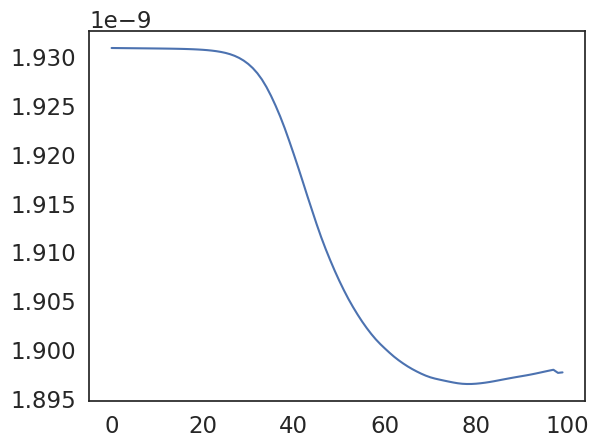

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.912940289080929e-09, GW-cost: 1.588614099165762e-12, Total cost: 1.912940289080929e-09
Final Wasserstein cost: 1.894802908074038e-09, GW-cost: 1.5583530560046312e-12, Total cost: 1.894802908074038e-09


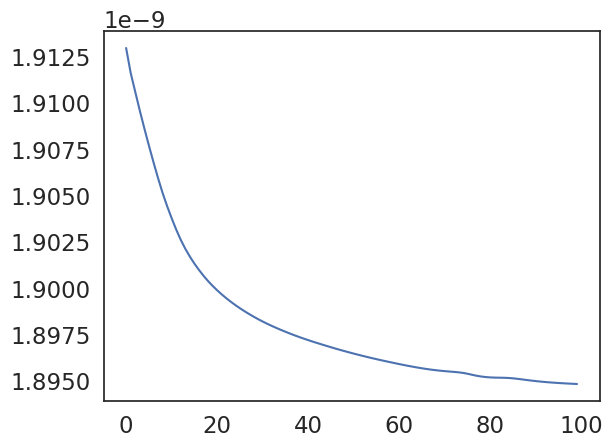

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.2612823170346227e-09, GW-cost: 6.895061690926369e-13, Total cost: 1.2612823170346227e-09
Final Wasserstein cost: 1.1827031479410662e-09, GW-cost: 6.563662567282976e-13, Total cost: 1.1827031479410662e-09


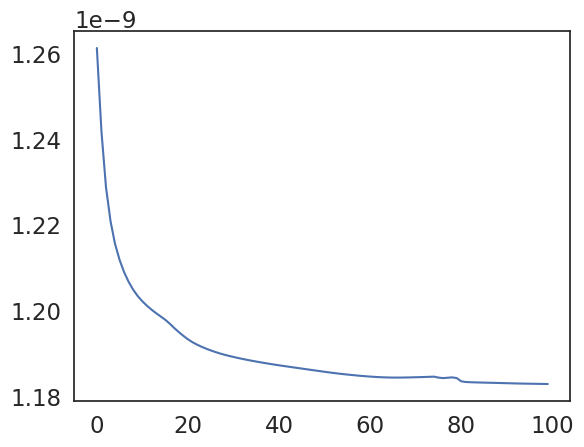

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.3709902786410763e-09, GW-cost: 5.917579143587979e-13, Total cost: 1.3709902786410763e-09
Final Wasserstein cost: 1.19390427961986e-09, GW-cost: 5.35511812416996e-13, Total cost: 1.19390427961986e-09


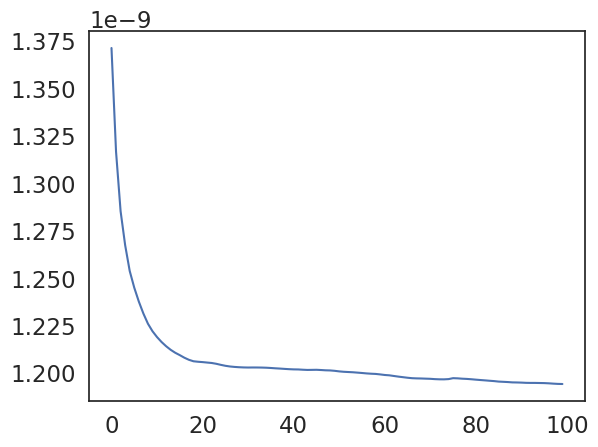

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.770304214667561e-09, GW-cost: 5.464301950034845e-13, Total cost: 1.770304214667561e-09
Final Wasserstein cost: 1.3117406568243973e-09, GW-cost: 4.570815312402826e-13, Total cost: 1.3117406568243973e-09


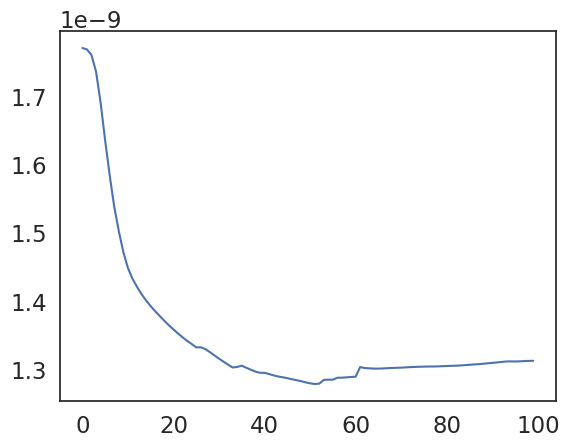

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.4206981807867838e-09, GW-cost: 5.997861516912905e-13, Total cost: 1.4206981807867838e-09
Final Wasserstein cost: 1.1627929461645457e-09, GW-cost: 5.631568687488253e-13, Total cost: 1.1627929461645457e-09


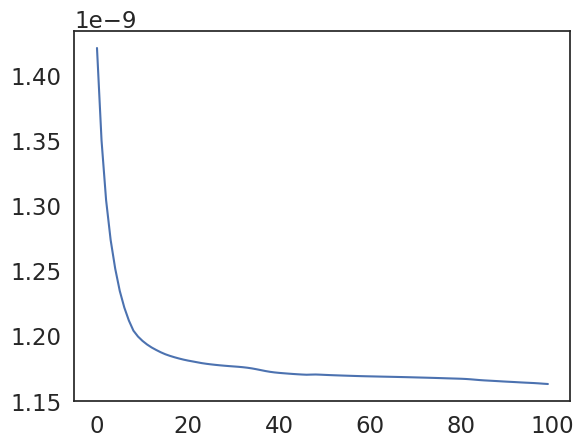

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.2398118148012866e-09, GW-cost: 6.899153923179709e-13, Total cost: 1.2398118148012866e-09
Final Wasserstein cost: 9.825875021491633e-10, GW-cost: 5.443576497569115e-13, Total cost: 9.825875021491633e-10


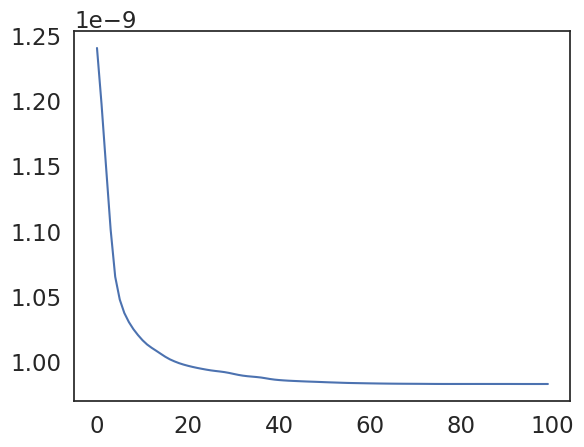

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.9154133533110993e-09, GW-cost: 1.6227747022985268e-12, Total cost: 1.9154133533110993e-09
Final Wasserstein cost: 1.8604397112568461e-09, GW-cost: 1.4051612950642634e-12, Total cost: 1.8604397112568461e-09


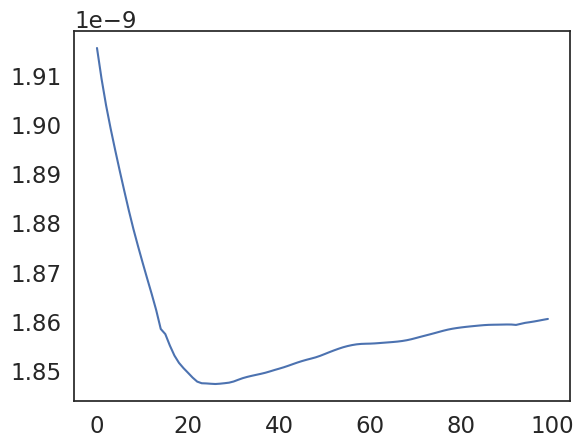

Ranks: r1 2, r2 9, r3 8
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 3.848188776682604e-09
Final Wasserstein-sum cost: 3.7717425026791185e-09


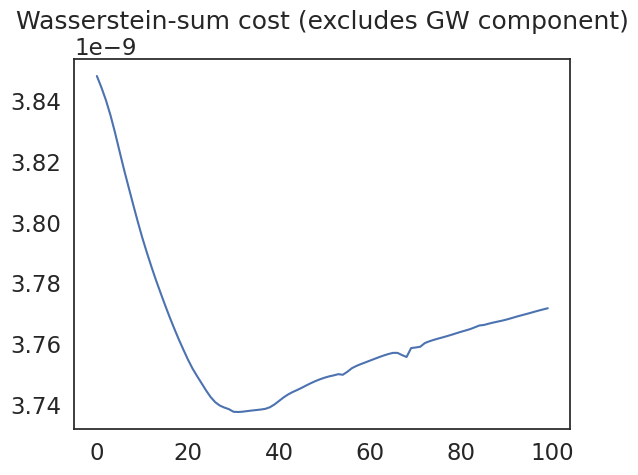

Ranks: r1 9, r2 8, r3 12
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 3.1596072538333555e-09
Final Wasserstein-sum cost: 2.88265540396674e-09


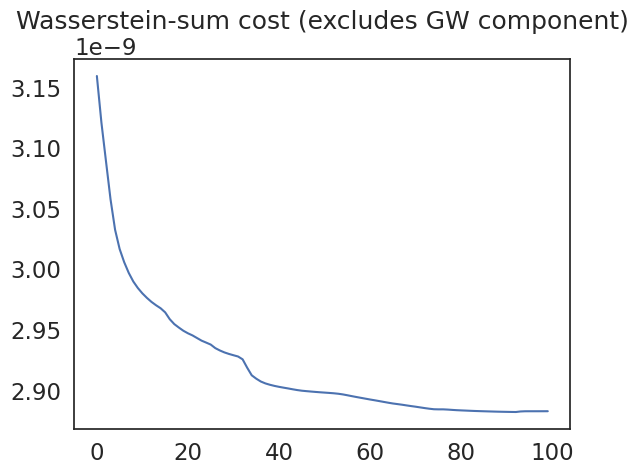

Ranks: r1 8, r2 12, r3 14
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 2.727499791740695e-09
Final Wasserstein-sum cost: 2.3520818900132042e-09


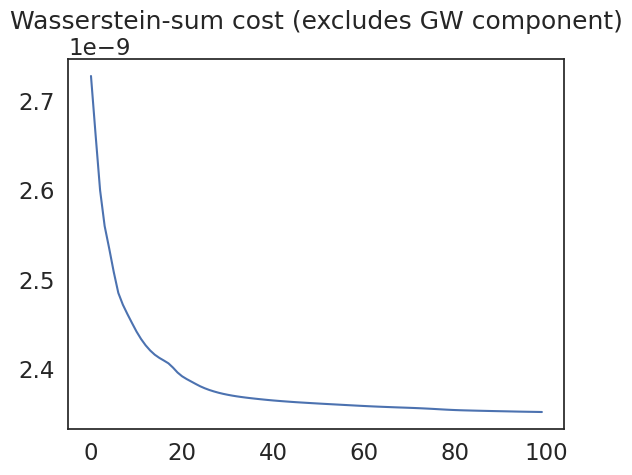

Ranks: r1 12, r2 14, r3 23
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein-sum cost: 3.0942271037445357e-09
Final Wasserstein-sum cost: 2.606923014282603e-09


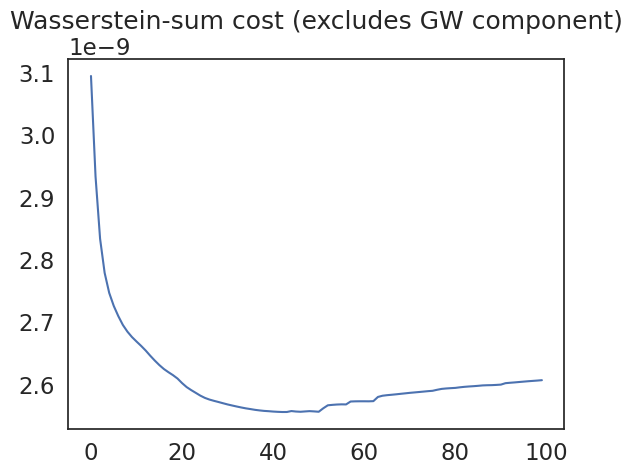

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.935036916510702e-09, GW-cost: 4.3469112213668705e-12, Total cost: 1.935036916510702e-09
Final Wasserstein cost: 1.897559488122635e-09, GW-cost: 4.056749585931704e-12, Total cost: 1.897559488122635e-09


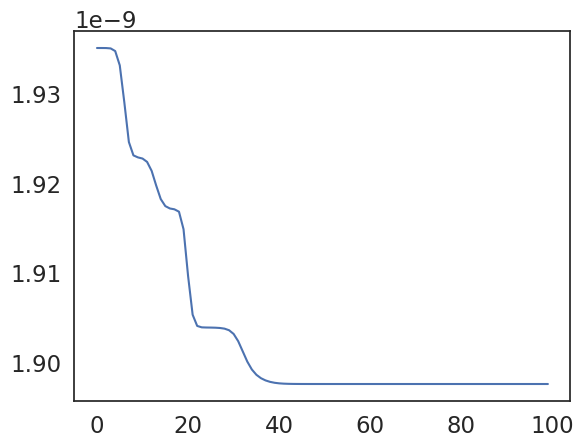

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.918725052137489e-09, GW-cost: 1.5305083077631908e-12, Total cost: 1.918725052137489e-09
Final Wasserstein cost: 1.873810717605704e-09, GW-cost: 1.4856686142623122e-12, Total cost: 1.873810717605704e-09


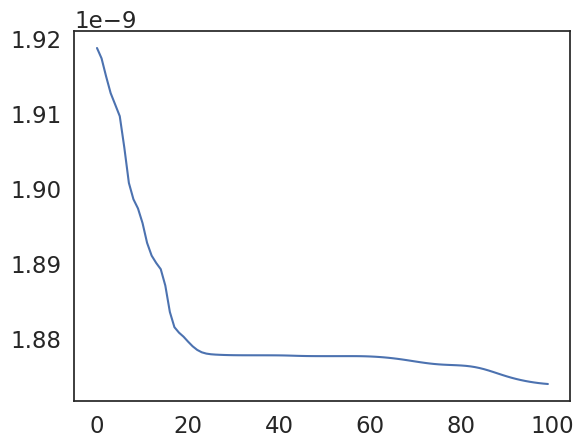

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.1014018856968266e-09, GW-cost: 6.272954063628031e-13, Total cost: 1.1014018856968266e-09
Final Wasserstein cost: 1.0032747997405456e-09, GW-cost: 5.329220806974081e-13, Total cost: 1.0032747997405456e-09


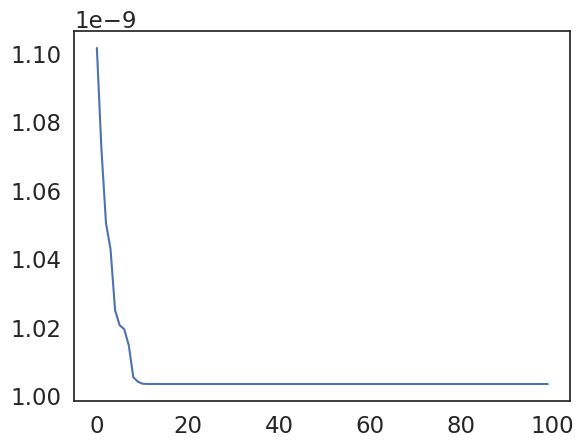

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.4942278333283833e-09, GW-cost: 6.177226311384616e-13, Total cost: 1.4942278333283833e-09
Final Wasserstein cost: 1.1837541707555343e-09, GW-cost: 5.364286391464217e-13, Total cost: 1.1837541707555343e-09


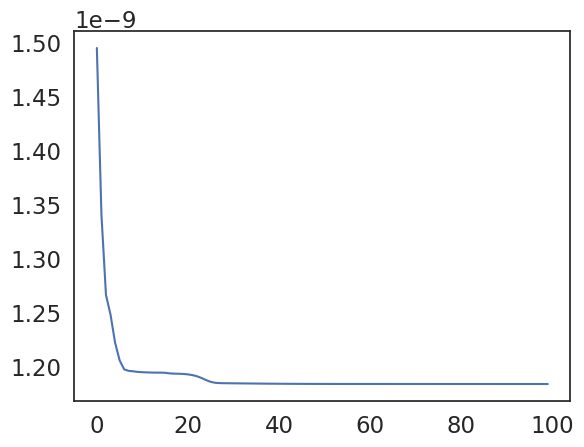

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Initial Wasserstein cost: 1.5469697196013813e-09, GW-cost: 4.836553977446588e-13, Total cost: 1.5469697196013813e-09
Final Wasserstein cost: 1.3799006313308344e-09, GW-cost: 4.4495788801360893e-13, Total cost: 1.3799006313308344e-09


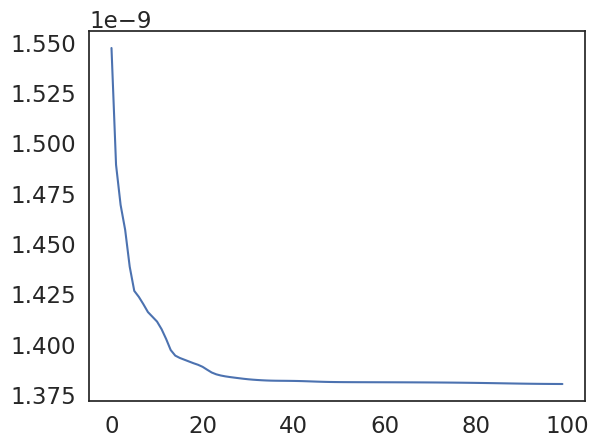

CPU times: user 5min 23s, sys: 4.93 s, total: 5min 28s
Wall time: 5min 22s


In [108]:
%%time
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)


WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=max_iter, min_iter=min_iter, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

Qs_pred = [Q.cpu().numpy() for Q in WDM.Q_gammas]
Ts_pred = [T.cpu().numpy() for T in WDM.T_gammas]

In [109]:
Ss = spatial_list

node_labels1 = [None for Q in WDM.Q_gammas]

clustering.plot_clusters_from_QT(Ss, Qs_pred, Ts_pred, node_labels1, dotsize=10)
clustering.diffmap_from_QT(Qs_pred, Ts_pred, cell_type_labels=node_labels1, dsf=.3)

Output hidden; open in https://colab.research.google.com to view.

## save

In [110]:
for i,Q in enumerate(WDM.Q_gammas):
    np.save(filehandle_save + f'wdm_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM.T_gammas):
    np.save(filehandle_save + f'wdm_T{i}{i+1}.npy', T.cpu().numpy())

## ari, ami

In [111]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [112]:
gt_types_list = clustering.max_likelihood_clustering(Qs_gt)
pred_types_list = clustering.max_likelihood_clustering(Qs_pred)

util_zf.compute_ARI_and_AMI(gt_types_list, pred_types_list)

ARI and AMI of predictions (filtered excludes ground truth clusters smaller than 5% of the data)

ARI for 0th slice is 0.312 (filtered: 0.312) 	
AMI for 0th slice is 0.320 (filtered: 0.320)


ARI for 1th slice is 0.151 (filtered: 0.176) 	
AMI for 1th slice is 0.267 (filtered: 0.287)


ARI for 2th slice is 0.350 (filtered: 0.363) 	
AMI for 2th slice is 0.462 (filtered: 0.474)


ARI for 3th slice is 0.312 (filtered: 0.331) 	
AMI for 3th slice is 0.492 (filtered: 0.508)


ARI for 4th slice is 0.435 (filtered: 0.491) 	
AMI for 4th slice is 0.574 (filtered: 0.622)


ARI for 5th slice is 0.225 (filtered: 0.219) 	
AMI for 5th slice is 0.472 (filtered: 0.471)




In [113]:
importlib.reload(util_zf)

<module 'util_zf' from '/content/drive/Othercomputers/numac/GitHub/WDM/util_zf.py'>

In [114]:
util_zf.silhouette(gt_types_list, pred_types_list, Xs, Ss)

	Pred clusters 0 have **LOWER** expression silhouette score: 0.261 < 0.325
	Pred clusters 1 have **LOWER** expression silhouette score: -0.164 < 0.190
	Pred clusters 2 have **LOWER** expression silhouette score: 0.144 < 0.160
	Pred clusters 3 have **HIGHER** expression silhouette score: 0.087 > 0.073
	Pred clusters 4 have **LOWER** expression silhouette score: 0.102 < 0.169
	Pred clusters 5 have **HIGHER** expression silhouette score: 0.064 > 0.060


	Pred clusters 0 have **LOWER** spatial silhouette score: 0.261 < 0.453
	Pred clusters 1 have **LOWER** spatial silhouette score: -0.164 < 0.381
	Pred clusters 2 have **LOWER** spatial silhouette score: 0.144 < 0.380
	Pred clusters 3 have **LOWER** spatial silhouette score: 0.087 < 0.340
	Pred clusters 4 have **LOWER** spatial silhouette score: 0.102 < 0.446
	Pred clusters 5 have **LOWER** spatial silhouette score: 0.064 < 0.372


In [ ]:
util_zf.cos_silhouette(gt_types_list, pred_types_list, Xs, Ss)

	Pred clusters 0 have **LOWER** expression cosine-silhouette score: 0.389 < 0.487
	Pred clusters 1 have **LOWER** expression cosine-silhouette score: -0.208 < 0.283
	Pred clusters 2 have **HIGHER** expression cosine-silhouette score: 0.261 > 0.243
	Pred clusters 3 have **HIGHER** expression cosine-silhouette score: 0.156 > 0.147


## freezing $Q$s with annotations, running `WDM`

In [ ]:
%%time
Q_annot = Qs_gt_tensor

importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                      gamma=gamma, max_iter=100, min_iter=100, device=device, dtype=torch.float64, \
                     printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                      initialization='Full', init_args=None)

WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)
T_gammas = WDM2.T_gammas

In [ ]:
for i,Q in enumerate(WDM2.Q_gammas):
    np.save(filehandle_save + f'ann_Q{i}.npy', Q.cpu().numpy())

for i,T in enumerate(WDM2.T_gammas):
    np.save(filehandle_save + f'ann_T{i}{i+1}.npy', T.cpu().numpy())

# Analysis part 1: entropy of transitions

In [ ]:
Ts_ann = T_gammas
Ts_pred = Ts_pred

## entropy functions

In [ ]:
importlib.reload(util_zf)

In [ ]:
util_zf.compare_T_entropies(Ts_ann, Ts_pred)
print('\n')
util_zf.compare_T_col_entropies(Ts_ann, Ts_pred)

In [ ]:
importlib.reload(util_zf)

In [ ]:
for i, (T_ann, T_pred) in enumerate(zip(Ts_ann, Ts_pred)):
    T_ann = T_ann.cpu().numpy()
    util_zf.plot_collision_profiles(T_ann, T_pred, title=f'Convergence profiles at slice {i+2}')

In [ ]:
clustering.diffmap_from_QT(Qs_gt, Ts_ann, cell_type_labels=ct_labels, dsf=.3)

## what about arg-secondmax? Does this have biological signal?

In [ ]:
labels_2nd = []

for Q in Qs_pred:
    # Get the indices of the sorted entries for each row
    sorted_indices = np.argsort(Q, axis=1)

    # Extract the second-to-last index (the second largest) from the sorted indices
    second_largest_indices = sorted_indices[:, -2]
    labels_2nd += [second_largest_indices]

In [ ]:
threshold = 0.1  # Example threshold as a percentage of the largest value

labels_consensus = []

for Q in Qs_pred:
    argmax_labels = np.argmax(Q, axis=1)
    sorted_indices = np.argsort(Q, axis=1)
    second_argmax_labels = sorted_indices[:, -2]

    # Get the largest and second largest values from Q
    largest_values = np.max(Q, axis=1)
    second_largest_values = Q[np.arange(Q.shape[0]), second_argmax_labels]

    # Apply the threshold to choose between argmax and second argmax
    consensus_labels = np.where((largest_values - second_largest_values) / largest_values < threshold,
                                second_argmax_labels, argmax_labels)

    # Convert consensus_labels (NumPy array) to a regular Python list of ints
    labels = consensus_labels.tolist()  # Convert the array to a list
    labels = [int(label) for label in labels]  # Ensure all elements are ints
    labels = np.array(labels)
    labels_consensus.append(labels)  # Use append to add the new list of labels

# Now labels_consensus is a list of lists, suitable for plotting
clustering.plot_clustering_list(Ss, labels_consensus, dotsize=10)

In [ ]:
util_zf.compute_ARI_and_AMI(gt_types_list, labels_consensus)

In [ ]:
from scipy.special import softmax

def sample_random_labeling(Q, T=1.0, epsilon=1e-12):
    # Step 1: Normalize Q row-wise to make it row-stochastic
    row_sums = Q.sum(axis=1, keepdims=True)
    P = Q / row_sums

    # Handle division by zero in case row sums are zero
    P = np.nan_to_num(P)

    # Step 2: Take the logarithm of each element (add epsilon to avoid log(0))
    L = np.log(P + epsilon)

    # Step 3: Apply the built-in softmax function with temperature scaling
    # Adjust the input by dividing by the temperature T
    S = softmax(L / T, axis=1)

    # Step 4: Sample a label for each row based on the probabilities in S
    num_rows, num_cols = S.shape
    random_labels = np.array([
        np.random.choice(num_cols, p=S[i])
        for i in range(num_rows)
    ])

    return random_labels

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ari

def get_ARI_and_AMI(gt_types_list, pred_types_list, x_percent=5):
    #print(f"ARI and AMI of predictions (filtered excludes ground truth clusters smaller than {x_percent}% of the data)\n")
    aris = []
    amis = []
    for i, (gt_types, pred_types) in enumerate(zip(gt_types_list, pred_types_list)):
        raw_ari = ari(gt_types, pred_types)
        raw_ami = ami(gt_types, pred_types)

        gt_labels = np.array(gt_types)
        pred_labels = np.array(pred_types)
        total_points = len(gt_labels)

        # Compute counts of ground truth clusters
        unique_labels, counts = np.unique(gt_labels, return_counts=True)
        percentages = counts / total_points * 100

        # Identify clusters to keep (clusters with size >= x%)
        clusters_to_keep = unique_labels[percentages >= x_percent]

        # Create a mask to keep only data points in clusters_to_keep
        mask = np.isin(gt_labels, clusters_to_keep)

        # Apply mask to both gt_labels and pred_labels
        gt_labels_filtered = gt_labels[mask]
        pred_labels_filtered = pred_labels[mask]

        # Compute ARI and AMI on the filtered labels
        x_ari = ari(gt_labels_filtered, pred_labels_filtered)
        x_ami = ami(gt_labels_filtered, pred_labels_filtered)

        aris += [x_ari]
        amis += [x_ami]

    return aris, amis

        #print(f'ARI for {i}th slice is {raw_ari:.3f} (filtered: {x_ari:.3f}) \t')
        #print(f'AMI for {i}th slice is {raw_ami:.3f} (filtered: {x_ami:.3f})')
        #print('\n')

In [ ]:
N_samples = 50

n_timepoints = len(Qs_pred)

scores = np.zeros((N_samples, n_timepoints, 2))


#for i in range(N_samples):


'''
for i in range(N_samples):

    labels_sampled = []

    for t, Q in enumerate(Qs_pred):
        random_labels = sample_random_labeling(Q, T=1e-3)
        labels_sampled.append(random_labels)  # Use append to add the new list of labels

    aris, amis = get_ARI_and_AMI(gt_types_list, labels_sampled)
    aris_inner_np = [ np.array(ari) for ari in aris ]
    amis_inner_np = [ np.array(ami) for ami in amis ]

    aris_np = np.array(aris_inner_np)
    amis_np = np.array(amis_inner_np)

    scores[i, :, 0] = aris_np
    scores[i, :, 1] = amis_np
''';

In [ ]:
print(np.mean(scores[:,:,0], axis=0))

In [ ]:
print(np.max(scores[:,:,0], axis=0))

# Analysis part 2: DE analysis

## load output of `WDM`

In [ ]:
wdm_Qs = []
wdm_Ts = []


wdm_Q0 = np.load(filehandle_save + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_save + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_save + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_save + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_save + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_save+ 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_save + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_save + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_save + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_save + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_save + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_save + 'ann_T0.npy')
ann_T1 = np.load(filehandle_save + 'ann_T1.npy')

### lists of these for the three cases

Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]

Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

Qs_wdm = [wdm_Q0, wdm_Q1, wdm_Q2]
Ts_wdm = [wdm_T0, wdm_T1]

## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [ ]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [ ]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

Ss = [S0, S1, S2]

## load labels

In [ ]:
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'

slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

target_value = 'Otic Vesicle'
# Find indices where the elements match the target value
indices = [index for index, value in enumerate(slice5_types) if value == 'Otic Vesicle']

print(f"Indices of '{target_value}' in the list: {indices}")

Indices of 'Otic Vesicle' in the list: [5041]


## case 1: `ml` clustering,  annotations

In [ ]:
type(slice5_types)

list

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann,
                        Ts=Ts_ann,
                        cell_type_labels=cell_type_labels_case_1,
                        clustering_type='ml')

## case 2: `ml` clustering, annotations at $t_1, t_3$

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_ann_imp,
                        Ts=Ts_ann_imp,
                        cell_type_labels=cell_type_labels_case_2,
                        clustering_type='ml')

## case 3: fully unsupervised

In [ ]:
importlib.reload(clustering)


clustering.both_from_QT(Ss=Ss,
                        Qs=Qs_wdm,
                        Ts=Ts_wdm,
                        cell_type_labels=cell_type_labels_case_3,
                        clustering_type='ml')

## focus on case 3, what does differential expression reveal about how these clusters compare to the annotations?

In [ ]:
pred_clustering_list = clustering.max_likelihood_clustering(Qs_wdm)
gt_clustering_list = clustering.max_likelihood_clustering(Qs_gt[2:5])

In [ ]:
pred_clustering_0 = pred_clustering_list[0]
pred_clustering_1 = pred_clustering_list[1]
pred_clustering_2 = pred_clustering_list[2]

## differential expression at 10hpf:

In [ ]:
_adata0 = adatas[2].copy()

_adata0.obs['diff_map_cluster'] = pred_clustering_0
_adata0.obs['diff_map_cluster'] = _adata0.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata0)
sc.pp.log1p(_adata0)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata0, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata0, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata0, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 10hpf

## differential expression at 12hpf:

In [ ]:
_adata1 = adatas[3].copy()

_adata1.obs['diff_map_cluster'] = pred_clustering_1
_adata1.obs['diff_map_cluster'] = _adata1.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata1)
sc.pp.log1p(_adata1)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata1, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata1, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata1, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 12hpf

## differential expression at 18hpf:

In [ ]:
_adata2 = adatas[4].copy()

_adata2.obs['diff_map_cluster'] = pred_clustering_2
_adata2.obs['diff_map_cluster'] = _adata2.obs['diff_map_cluster'].astype('category')
sc.pp.normalize_total(_adata2)
sc.pp.log1p(_adata2)

# Differential gene expression analysis
sc.tl.rank_genes_groups(_adata2, groupby='diff_map_cluster', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")

# Bin-annotation
sc.tl.rank_genes_groups(_adata2, groupby='bin_annotation', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(_adata2, n_genes=10, sharey=False, key = "t-test")


## most interesting predicted clusters at 18hpf